In [3]:
import os
import pandas as pd
import glob
import numpy as np

import xgboost
print(xgboost.__version__)

from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import KFold
from xgboost import XGBRegressor

%config InlineBackend.figure_formatrmat = 'retina'
import matplotlib.pyplot as plt
plt.style.use('ggplot')

/Users/kmenear/Projects/sulfurTES/sulfurTESenv/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


1.5.0


In [4]:
data_dir = "../data/Air_Models/"

scenario_index = pd.DataFrame({"filepath": glob.glob(os.path.join(data_dir, "IG_*_*.csv"))})
scenario_index

,filepath
0,../data/Air_Models/IG_500_390.csv
1,../data/Air_Models/IG_520_300.csv
2,../data/Air_Models/IG_530_300.csv
3,../data/Air_Models/IG_600_560.csv
4,../data/Air_Models/IG_600_400.csv
...,...
135,../data/Air_Models/IG_370_300.csv
136,../data/Air_Models/IG_600_550.csv
137,../data/Air_Models/IG_600_430.csv
138,../data/Air_Models/IG_550_340.csv


In [5]:
cv = RepeatedKFold(n_splits=5, n_repeats=1, random_state=5)

train_index, test_index  = next(cv.split(scenario_index.index))

#train_index, test_index = cv.split(range(50))
 
print("TRAIN:", train_index, "TEST:", test_index)
print("TRAIN count:", len(train_index), "TEST count:", len(test_index))

TRAIN: [  0   1   2   3   4   5   6   7   8   9  11  13  14  15  16  17  18  19
  20  22  24  26  27  28  29  30  31  32  33  34  35  36  37  38  39  41
  42  44  45  47  49  51  55  56  57  58  59  61  62  63  64  65  67  68
  69  71  72  73  76  77  78  79  80  81  82  83  84  85  86  87  88  91
  92  93  95  96  97  99 100 101 103 104 105 106 110 112 113 114 115 116
 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135
 136 137 138 139] TEST: [ 10  12  21  23  25  40  43  46  48  50  52  53  54  60  66  70  74  75
  89  90  94  98 102 107 108 109 111 117]
TRAIN count: 112 TEST count: 28


In [6]:
def load_data(scenario_index, selected_index):
    """ Load data from files in scenario_index with indices matching ones in selected_index"""
    
    df_arr = []
    for f in scenario_index.loc[selected_index].filepath:
        Tw = float(f.split("/")[-1].split("_")[1])
        Ti = float(f.split("/")[-1].split("_")[2].replace(".csv", ""))

        f_df = pd.read_csv(f, skiprows=12)
        f_df["Tw"] = Tw
        f_df["Ti"] = Ti
        df_arr.append(f_df)
    
    combined_df = pd.concat(df_arr)
    return combined_df

In [7]:
def load_test_data(scenario_index, selected_index):
    """ Load data from files in scenario_index with indices matching ones in selected_index"""
    
    df_arr = []
    for f in scenario_index.loc[selected_index].filepath:
        Tw = float(f.split("/")[-1].split("_")[1])
        Ti = float(f.split("/")[-1].split("_")[2].replace(".csv", ""))

        f_df = pd.read_csv(f, skiprows=12)
        f_df["Tw"] = Tw
        f_df["Ti"] = Ti
        df_arr.append(f_df)

    return df_arr

In [8]:
train_df = load_data(scenario_index, train_index)
train_df

,Time,Tc,Tf,Pc,Ra_d,Nu_d,h,dT/dt,rho,beta,k,cp,visc,Pr,cp.1,Tw,Ti
0,0.00,390.000,445.000,1300000.000,518600.0,12.100,31.83,40.0100,10.154148,0.002247,0.0263,1007,0.000018,0.706814,1007,500.0,390.0
1,0.01,390.400,445.200,1301333.636,517100.0,12.090,31.80,39.8300,10.159997,0.002246,0.0263,1007,0.000018,0.706814,1007,500.0,390.0
2,0.02,390.798,445.399,1302661.343,515600.0,12.080,31.78,39.6500,10.165816,0.002245,0.0263,1007,0.000018,0.706814,1007,500.0,390.0
3,0.03,391.195,445.597,1303983.152,514000.0,12.070,31.75,39.4800,10.171603,0.002244,0.0263,1007,0.000018,0.706814,1007,500.0,390.0
4,0.04,391.590,445.795,1305299.092,512500.0,12.060,31.72,39.3000,10.177359,0.002243,0.0263,1007,0.000018,0.706814,1007,500.0,390.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2111,21.11,498.598,499.299,1661994.056,7647.0,4.103,10.79,0.1729,11.569879,0.002003,0.0263,1007,0.000018,0.706814,1007,500.0,410.0
2112,21.12,498.600,499.300,1661999.818,7638.0,4.102,10.79,0.1726,11.569899,0.002003,0.0263,1007,0.000018,0.706814,1007,500.0,410.0
2113,21.13,498.602,499.301,1662005.571,7628.0,4.100,10.78,0.1723,11.569919,0.002003,0.0263,1007,0.000018,0.706814,1007,500.0,410.0
2114,21.14,498.603,499.302,1662011.316,7619.0,4.099,10.78,0.1721,11.569939,0.002003,0.0263,1007,0.000018,0.706814,1007,500.0,410.0


In [9]:
# transform a time series dataset into a supervised learning dataset
# source: https://machinelearningmastery.com/random-forest-for-time-series-forecasting/
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    #n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols = list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    # put it all together
    agg = pd.concat(cols, axis=1)
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

In [10]:
train = train_df[["Time", "Tw", "Ti", "Tc"]].to_numpy()
train

array([[0.00000e+00, 5.00000e+02, 3.90000e+02, 3.90000e+02],
       [1.00000e-02, 5.00000e+02, 3.90000e+02, 3.90400e+02],
       [2.00000e-02, 5.00000e+02, 3.90000e+02, 3.90798e+02],
       ...,
       [2.11300e+01, 5.00000e+02, 4.10000e+02, 4.98602e+02],
       [2.11400e+01, 5.00000e+02, 4.10000e+02, 4.98603e+02],
       [2.11500e+01, 5.00000e+02, 4.10000e+02, 4.98605e+02]])

In [11]:
train_shift = series_to_supervised(train)
df_ts = pd.DataFrame(train_shift)
df_ts.drop(df_ts[df_ts[0] == 21.15].index, inplace = True)
train_shift = df_ts.to_numpy()
train_shift

array([[0.00000e+00, 5.00000e+02, 3.90000e+02, ..., 5.00000e+02,
        3.90000e+02, 3.90400e+02],
       [1.00000e-02, 5.00000e+02, 3.90000e+02, ..., 5.00000e+02,
        3.90000e+02, 3.90798e+02],
       [2.00000e-02, 5.00000e+02, 3.90000e+02, ..., 5.00000e+02,
        3.90000e+02, 3.91195e+02],
       ...,
       [2.11200e+01, 5.00000e+02, 4.10000e+02, ..., 5.00000e+02,
        4.10000e+02, 4.98602e+02],
       [2.11300e+01, 5.00000e+02, 4.10000e+02, ..., 5.00000e+02,
        4.10000e+02, 4.98603e+02],
       [2.11400e+01, 5.00000e+02, 4.10000e+02, ..., 5.00000e+02,
        4.10000e+02, 4.98605e+02]])

In [12]:
test_data = load_test_data(scenario_index, test_index)
count = 0
test_df_list = list()
for test_df in test_data:
    test = test_df[["Time", "Tw", "Ti", "Tc"]].to_numpy()
    test_shift = series_to_supervised(test)
    test_df_list.append(test_shift)

In [13]:
X_train, Y_train = train_shift[:, 0:-4], train_shift[:, -1]
print(X_train)
print(Y_train)

[[0.00000e+00 5.00000e+02 3.90000e+02 3.90000e+02]
 [1.00000e-02 5.00000e+02 3.90000e+02 3.90400e+02]
 [2.00000e-02 5.00000e+02 3.90000e+02 3.90798e+02]
 ...
 [2.11200e+01 5.00000e+02 4.10000e+02 4.98600e+02]
 [2.11300e+01 5.00000e+02 4.10000e+02 4.98602e+02]
 [2.11400e+01 5.00000e+02 4.10000e+02 4.98603e+02]]
[390.4   390.798 391.195 ... 498.602 498.603 498.605]


In [14]:
X_test = list()
Y_test = list()
for test_shift in test_df_list:
    X, Y = test_shift[:, 0:-5], test_shift[:, -1]
    X_test.append(X)
    Y_test.append(Y)

In [15]:
fw = np.array([1., 1., 1., 0.5])

In [16]:
model = XGBRegressor(objective='reg:squarederror', n_estimators=10000, colsample_bytree=.75)
model.fit(X_train, Y_train, feature_weights=fw)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.75,
             enable_categorical=False, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=10000, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [17]:
def walk_forward_validation(X_test_sample):
    predictions = list()
    Tc = X_test_sample[0][2]
    for time_step in X_test_sample:
        time_step = np.append(time_step,Tc)
        Tc = model.predict(time_step.reshape(1, -1))
        predictions.append(Tc.tolist()[0])
    return np.array(predictions)

In [18]:
count = 0
Y_hat = list()
for X_test_sample in X_test:
    Y_hat_sample = walk_forward_validation(X_test_sample)
    Y_hat.append(Y_hat_sample)
    print('Predictions:', Y_hat_sample)
    print('Expected values:', Y_test[count])
    count += 1

Predictions: [372.17840576 373.20303345 375.03619385 ... 597.94317627 597.94293213
 598.02545166]
Expected values: [370.928 371.852 372.771 ... 597.835 597.838 597.841]
Predictions: [301.02676392 302.27020264 303.56295776 ... 587.71020508 587.7701416
 587.7835083 ]
Expected values: [301.193 302.382 303.565 ... 587.693 587.697 587.7  ]
Predictions: [300.13742065 300.23376465 300.36477661 ... 339.18362427 339.18569946
 339.18609619]
Expected values: [300.088 300.176 300.263 ... 329.285 329.286 329.287]
Predictions: [410.86523438 410.77218628 411.63540649 ... 548.30413818 548.30487061
 548.30908203]
Expected values: [410.526 411.049 411.569 ... 548.266 548.268 548.271]
Predictions: [498.87542725 498.51205444 498.98391724 ... 577.63922119 577.63739014
 577.63702393]
Expected values: [500.261 500.52  500.779 ... 578.527 578.529 578.53 ]
Predictions: [499.17495728 498.54473877 498.8062439  ... 548.85162354 548.85357666
 548.85559082]
Expected values: [500.147 500.293 500.439 ... 548.809 548.

In [19]:
print(Y_hat)
Y_hat_temp = list()
for Y_hat_sample in Y_hat:
    for datapoint in Y_hat_sample:
        Y_hat_temp.append(datapoint)
    Y_hat_temp.append(Y_hat_sample[-1])


Y_hat_temp = np.array(Y_hat_temp)
print(Y_hat_temp)

[array([372.17840576, 373.20303345, 375.03619385, ..., 597.94317627,
       597.94293213, 598.02545166]), array([301.02676392, 302.27020264, 303.56295776, ..., 587.71020508,
       587.7701416 , 587.7835083 ]), array([300.13742065, 300.23376465, 300.36477661, ..., 339.18362427,
       339.18569946, 339.18609619]), array([410.86523438, 410.77218628, 411.63540649, ..., 548.30413818,
       548.30487061, 548.30908203]), array([498.87542725, 498.51205444, 498.98391724, ..., 577.63922119,
       577.63739014, 577.63702393]), array([499.17495728, 498.54473877, 498.8062439 , ..., 548.85162354,
       548.85357666, 548.85559082]), array([300.19421387, 300.37362671, 300.77999878, ..., 358.99533081,
       358.99905396, 358.99490356]), array([486.05621338, 486.24401855, 486.37820435, ..., 498.63827515,
       498.63964844, 498.6399231 ]), array([304.23059082, 305.52023315, 307.17825317, ..., 486.42199707,
       486.41333008, 486.40319824]), array([399.48474121, 399.60427856, 399.59677124, ..., 

In [20]:
#test_df["Tc_hat"] = np.append(Y_hat_temp, Y_hat_temp[-1])
test_df = load_data(scenario_index, test_index)
test_df["Tc_hat"] = Y_hat_temp
test_df

,Time,Tc,Tf,Pc,Ra_d,Nu_d,h,dT/dt,rho,beta,k,cp,visc,Pr,cp.1,Tw,Ti,Tc_hat
0,0.00,370.000,485.000,1233333.333,753900.0,13.420,35.310,92.80000,8.838913,0.002062,0.0263,1007,0.000018,0.706814,1007,600.0,370.0,372.178406
1,0.01,370.928,485.464,1236426.650,752400.0,13.420,35.290,92.38000,8.852613,0.002060,0.0263,1007,0.000018,0.706814,1007,600.0,370.0,373.203033
2,0.02,371.852,485.926,1239505.853,751000.0,13.410,35.270,91.95000,8.866224,0.002058,0.0263,1007,0.000018,0.706814,1007,600.0,370.0,375.036194
3,0.03,372.771,486.386,1242570.998,749500.0,13.400,35.250,91.53000,8.879747,0.002056,0.0263,1007,0.000018,0.706814,1007,600.0,370.0,376.400208
4,0.04,373.687,486.843,1245622.143,748100.0,13.400,35.230,91.12000,8.893183,0.002054,0.0263,1007,0.000018,0.706814,1007,600.0,370.0,378.333221
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2111,21.11,549.421,549.711,1831404.559,2872.0,3.279,8.624,0.05703,11.580045,0.001819,0.0263,1007,0.000018,0.706814,1007,550.0,540.0,542.055237
2112,21.12,549.422,549.711,1831406.460,2869.0,3.279,8.622,0.05696,11.580051,0.001819,0.0263,1007,0.000018,0.706814,1007,550.0,540.0,541.771912
2113,21.13,549.423,549.711,1831408.359,2866.0,3.278,8.621,0.05689,11.580057,0.001819,0.0263,1007,0.000018,0.706814,1007,550.0,540.0,541.818787
2114,21.14,549.423,549.712,1831410.255,2864.0,3.277,8.619,0.05682,11.580063,0.001819,0.0263,1007,0.000018,0.706814,1007,550.0,540.0,541.775146


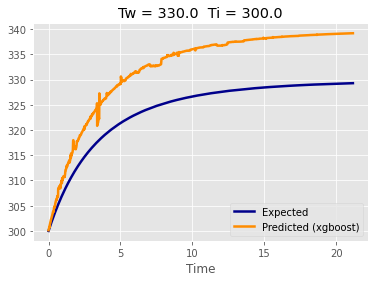

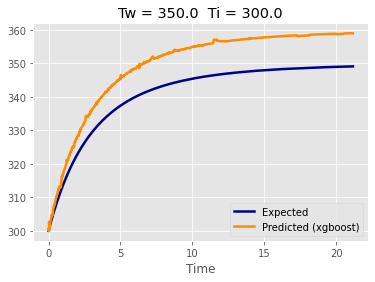

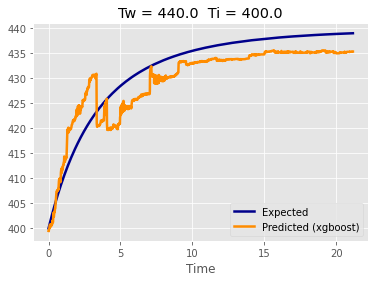

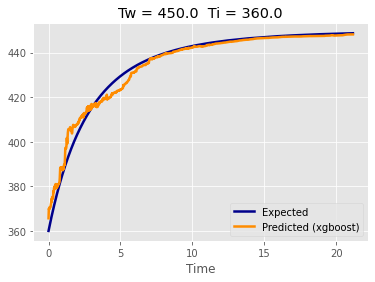

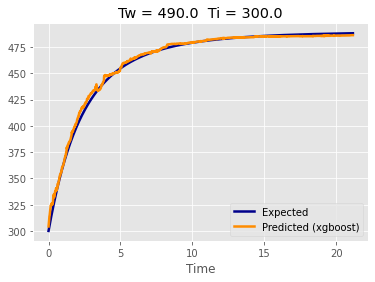

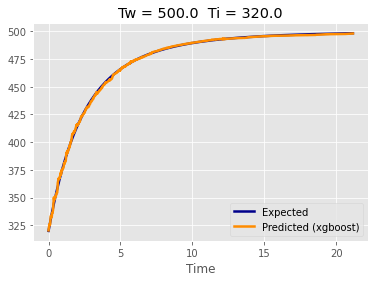

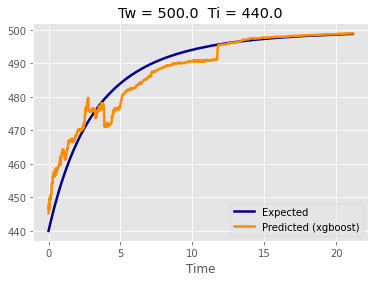

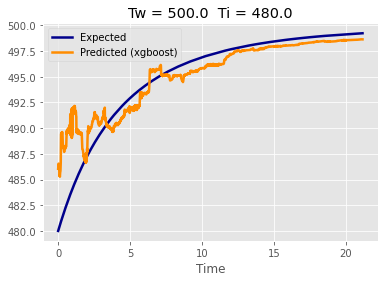

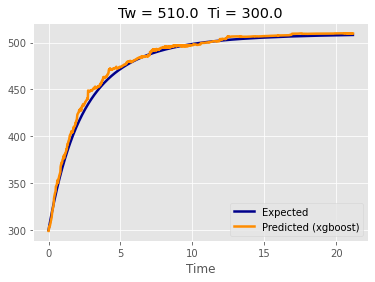

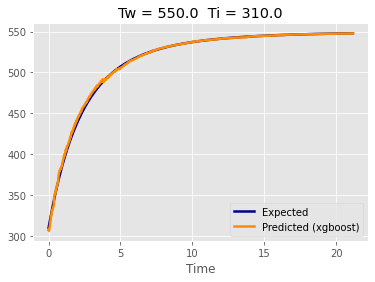

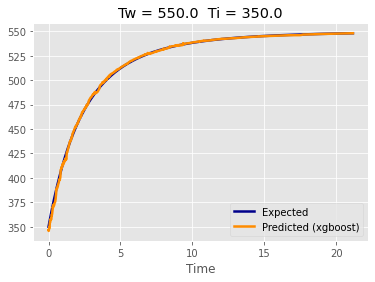

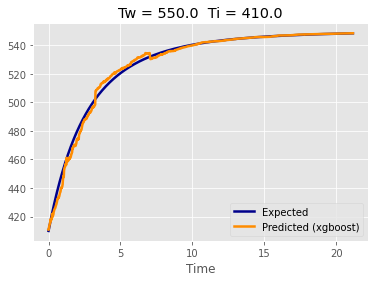

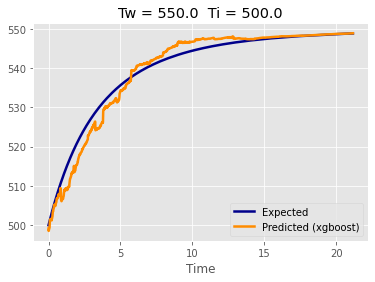

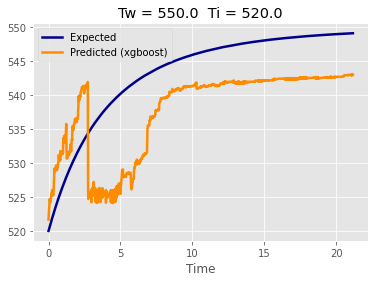

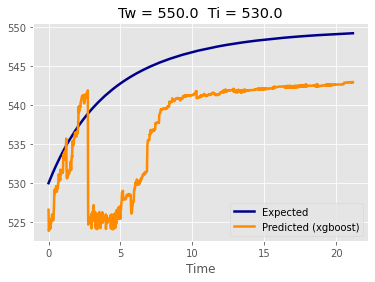

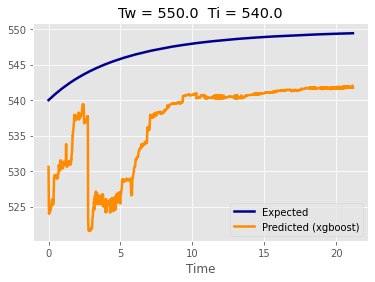

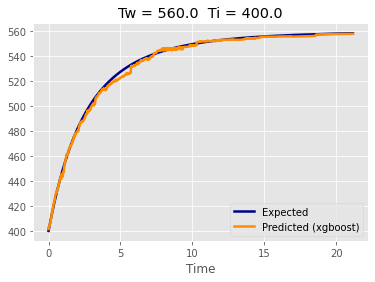

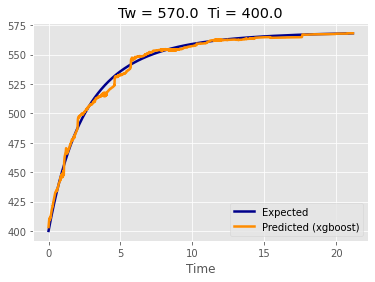

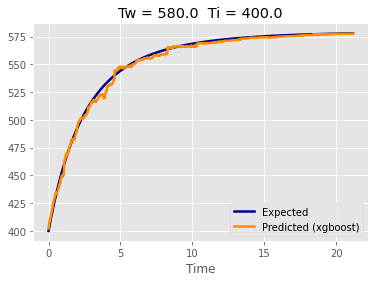

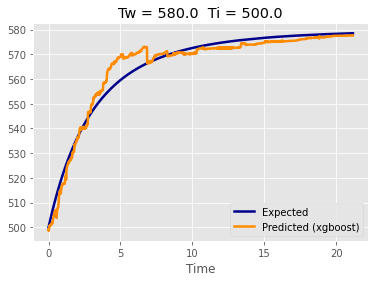

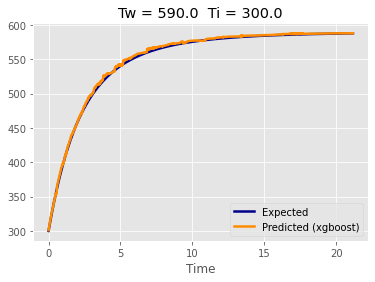

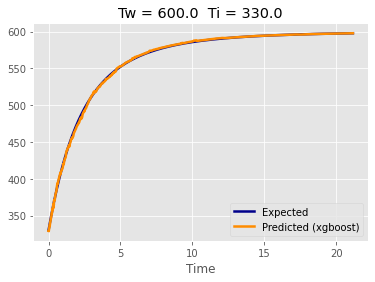

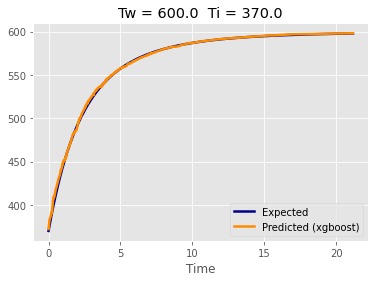

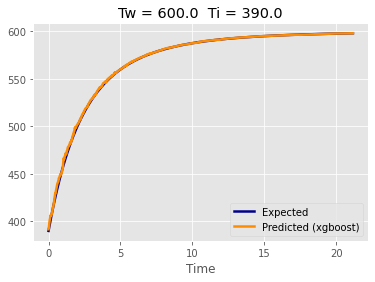

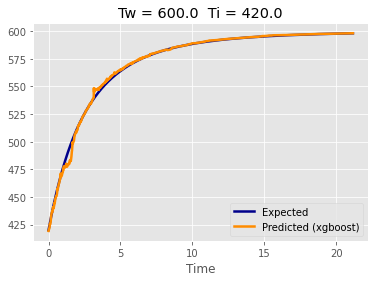

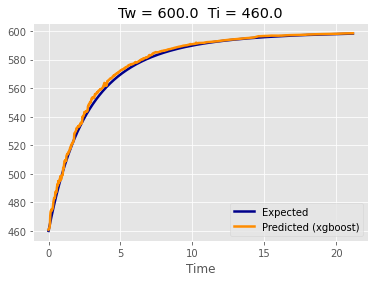

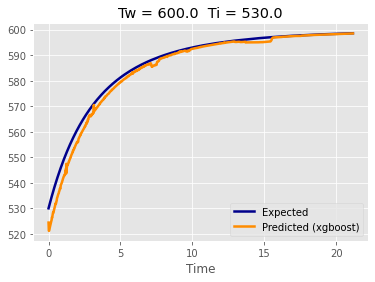

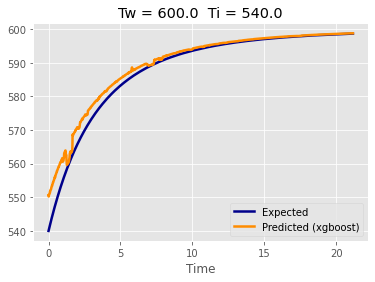

In [28]:
import matplotlib
for idx, grp in test_df.groupby(["Tw", "Ti"]):
    ax = grp.plot(x="Time", y='Tc', c='DarkBlue', linewidth=2.5, label="Expected")
    plot = grp.plot(x="Time", y='Tc_hat', c='DarkOrange', linewidth=2.5, label="Predicted (xgboost)", ax=ax)
    plt.title('Tw = {Tw}  Ti = {Ti}'.format(Tw=idx[0], Ti=idx[1]))
    #plot.set_ylim(bottom=300.0,top=600.0)
    plt.show()

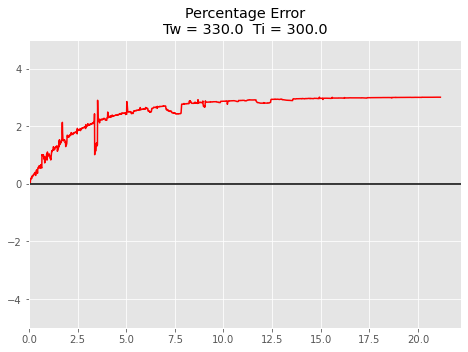

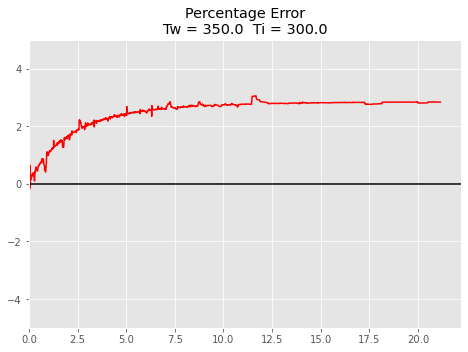

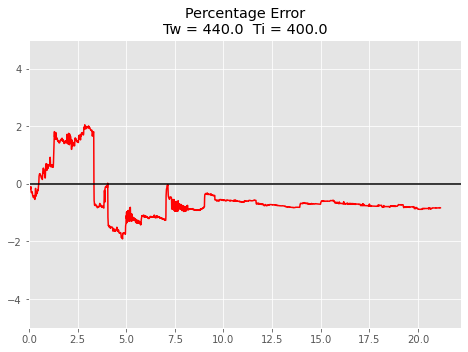

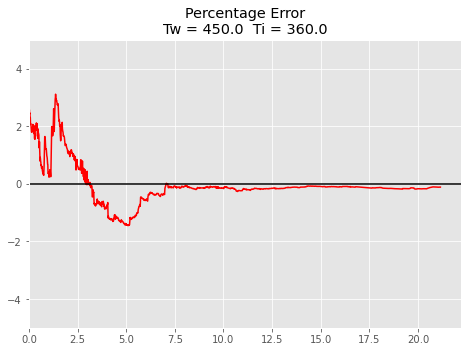

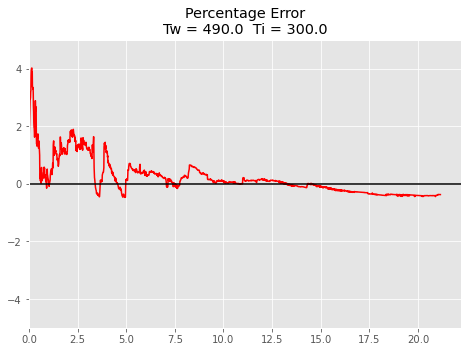

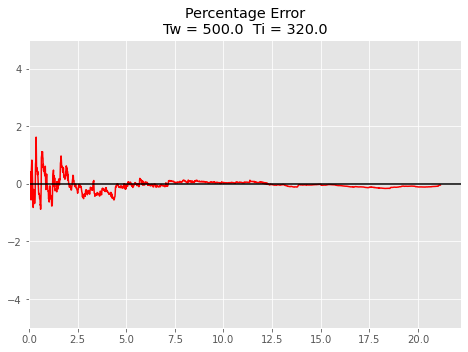

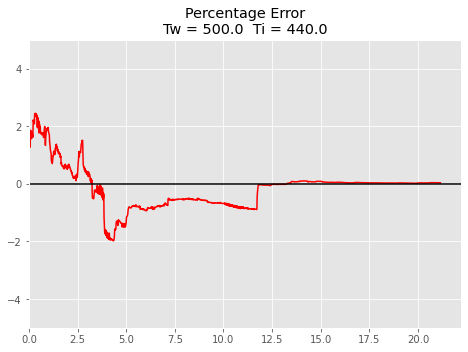

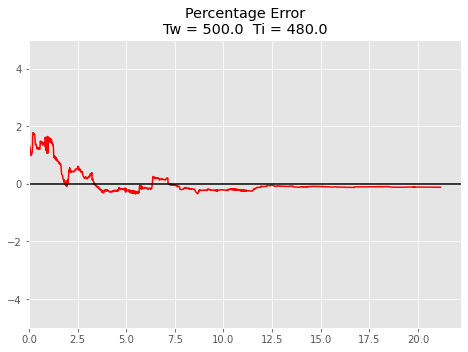

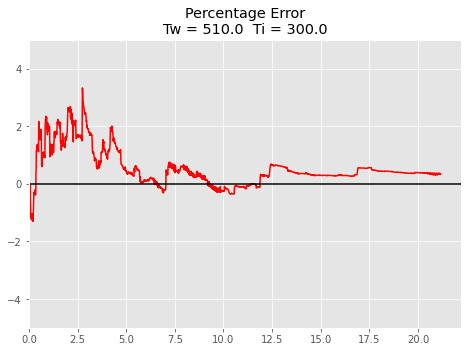

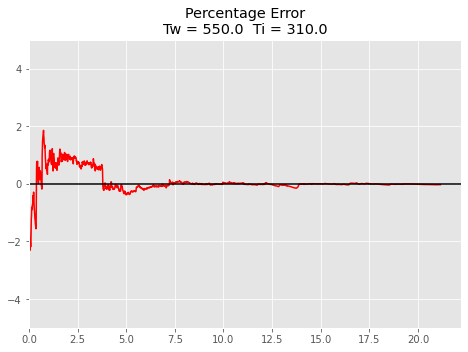

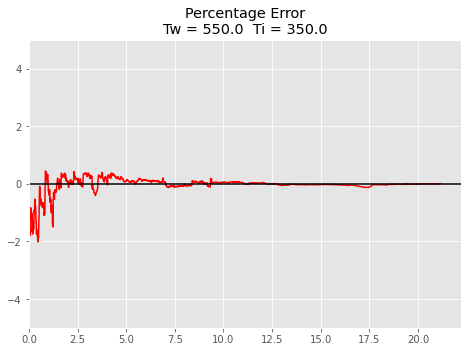

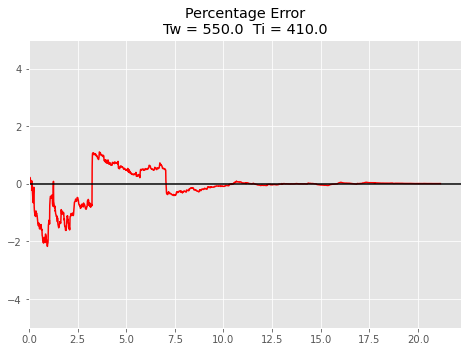

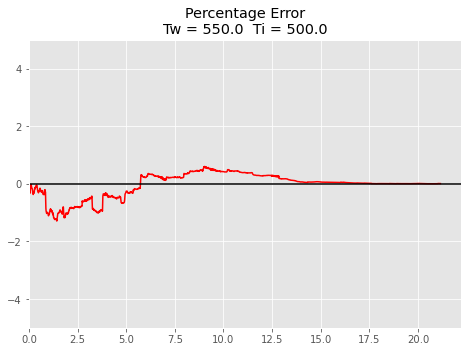

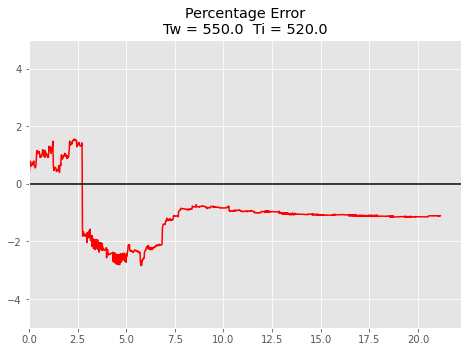

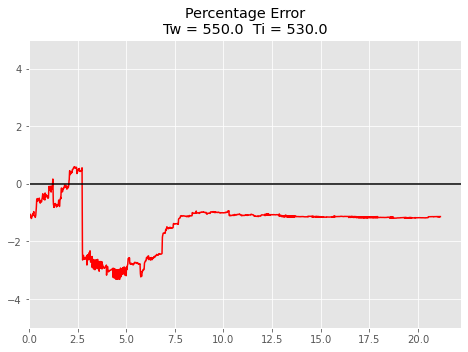

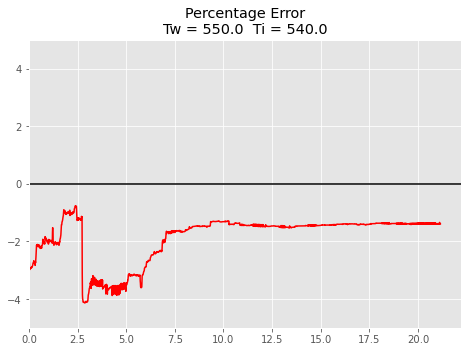

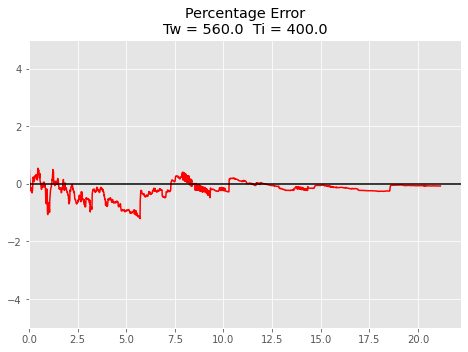

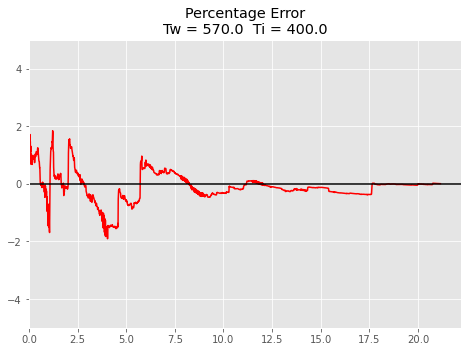

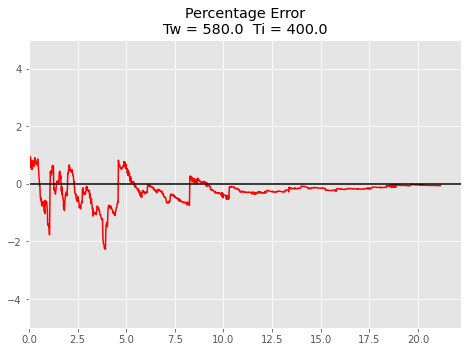

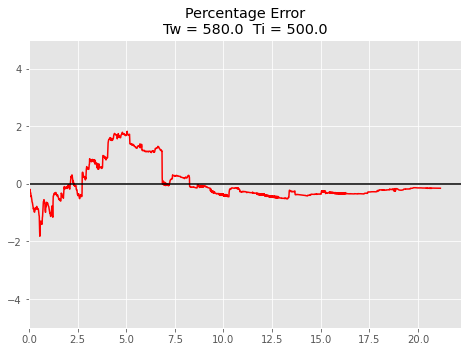

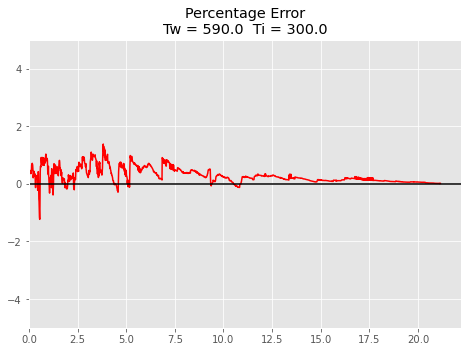

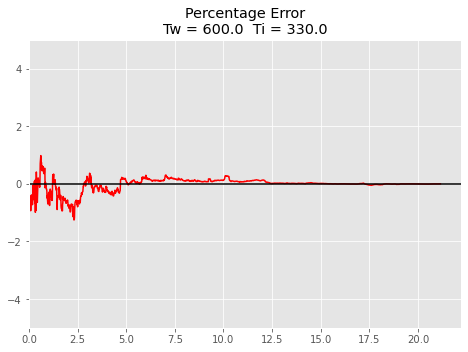

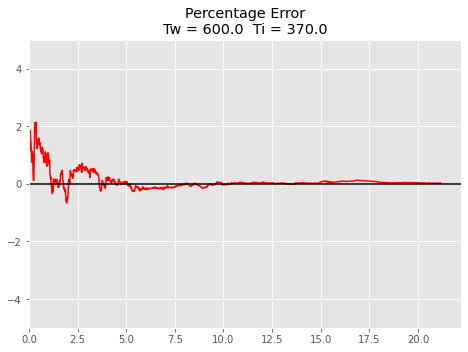

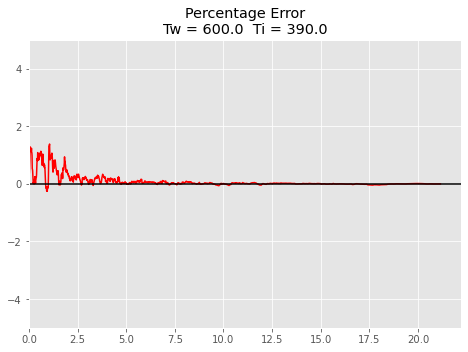

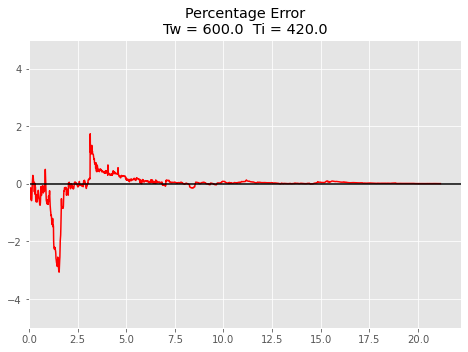

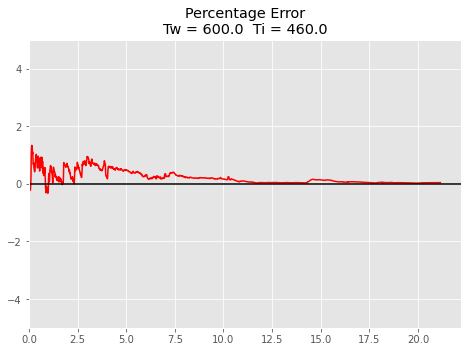

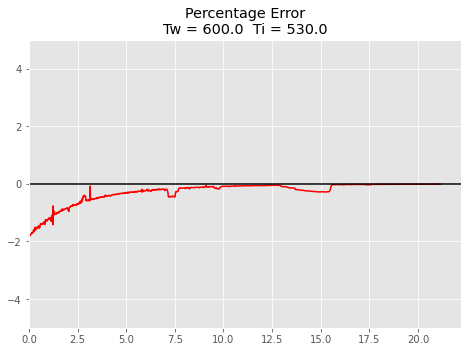

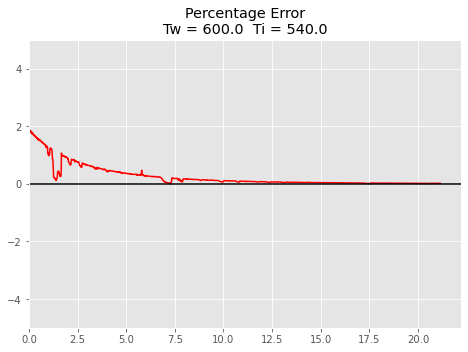

In [22]:
import matplotlib
for idx, grp in test_df.groupby(["Tw", "Ti"]):
    err = 100*(grp['Tc_hat'] - grp['Tc'])/grp['Tc']
    ax = plt.figure().add_axes([0,0,1,1])
    ax.plot(grp['Time'], err, color='r')
    ax.set_ylim(bottom=-5,top=5)
    ax.set_xlim(left=0)
    plt.title('Percentage Error\nTw = {Tw}  Ti = {Ti}'.format(Tw=idx[0], Ti=idx[1]))
    plt.axhline(0, color='black')
    plt.show()

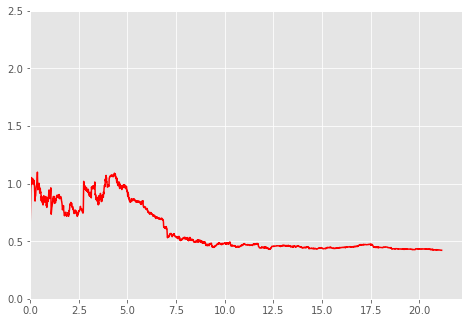

In [27]:
count = 0
for idx, grp in test_df.groupby(["Tw", "Ti"]):
    if count == 0:
        avg_err = abs(100*(grp['Tc_hat'] - grp['Tc'])/grp['Tc'])
    else:
        avg_err += abs(100*(grp['Tc_hat'] - grp['Tc'])/grp['Tc'])
    count += 1

avg_err /= count
ax = plt.figure().add_axes([0,0,1,1])
ax.plot(grp['Time'], avg_err, color='r')
ax.set_ylim(bottom=0,top=2.5)
ax.set_xlim(left=0)
#plt.title('Average Percentage Error at Time Step t')
#plt.axhline(0, color='black')
plt.show()

In [23]:
perc_err = (test_df["Tc_hat"] - test_df["Tc"])/test_df["Tc"]
avg_err = 0
cnt = 0
for item in perc_err:
    avg_err += abs(item)
    cnt += 1

avg_err /= cnt
acc = 1 - avg_err
print('Accuracy:',acc)

Accuracy: 0.994063915618655


<AxesSubplot:>

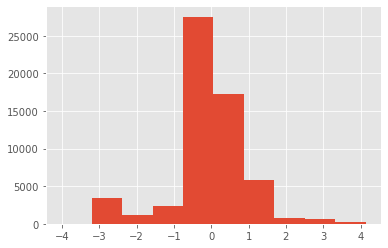

In [24]:
(100*(test_df["Tc"] - test_df["Tc_hat"])/test_df["Tc"]).hist()

<AxesSubplot:>

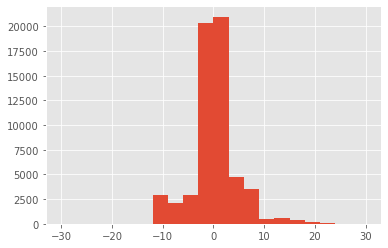

In [26]:
(test_df["Tc"] - test_df["Tc_hat"]).hist(bins=20, range=(-30, 30))

In [273]:
Tdiff_err = [[],[]]
for idx, grp in test_df.groupby(["Tw", "Ti"]):
    grp_diff = abs(grp["Tc"] - grp["Tc_hat"])
    avg_err = grp_diff.sum()
    T_diff = idx[0] - idx[1]
    print(idx, T_diff, avg_err)
    Tdiff_err[0].append(T_diff)
    Tdiff_err[1].append(avg_err)

(330.0, 300.0) 30.0 17721.010045898438
(350.0, 300.0) 50.0 18137.19935546875
(440.0, 400.0) 40.0 7902.074118164064
(450.0, 360.0) 90.0 3716.426907226562
(490.0, 300.0) 190.0 3749.131353515624
(500.0, 320.0) 180.0 1178.433284667968
(500.0, 440.0) 60.0 5140.569288330078
(500.0, 480.0) 20.0 2547.3118161621087
(510.0, 300.0) 210.0 5680.146549804687
(550.0, 310.0) 240.0 1718.8548542480476
(550.0, 350.0) 200.0 1208.2450698242164
(550.0, 410.0) 140.0 3218.2277307128907
(550.0, 500.0) 50.0 3332.7965515136716
(550.0, 520.0) 30.0 14546.86634277344
(550.0, 530.0) 20.0 15905.477990234374
(550.0, 540.0) 10.0 21314.310376953126
(560.0, 400.0) 160.0 2712.7170212402343
(570.0, 400.0) 170.0 3817.140249023439
(580.0, 400.0) 180.0 3606.052830566406
(580.0, 500.0) 80.0 5653.137996826172
(590.0, 300.0) 290.0 3303.4284567871086
(600.0, 330.0) 270.0 1418.6274455566413
(600.0, 370.0) 230.0 1592.7978930664067
(600.0, 390.0) 210.0 930.5829296874996
(600.0, 420.0) 180.0 1762.9767626953112
(600.0, 460.0) 140.0 25

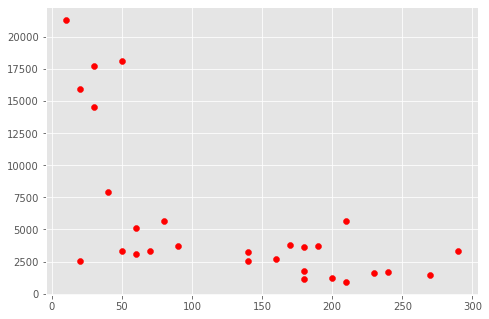

In [274]:
ax = plt.figure().add_axes([0,0,1,1])
ax.scatter(Tdiff_err[0], Tdiff_err[1], color='r')
plt.show()

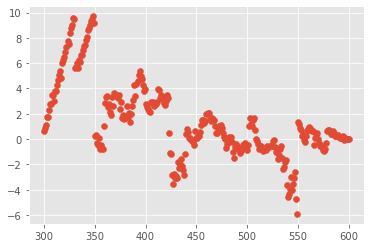

In [275]:
import math

avg_tc_diff = {}

for i in range(300, 601):
    avg_tc_diff[i] = [0,0]

tc_hat_list = test_df['Tc_hat'].tolist()
for i, temp in enumerate(test_df["Tc"]):
    avg_tc_diff[math.floor(temp)][0] += tc_hat_list[i] - temp
    avg_tc_diff[math.floor(temp)][1] += 1

temp = []
diff = []
for key, value in avg_tc_diff.items():
    if avg_tc_diff[key][1] > 0:
        avg_tc_diff[key][0] /= avg_tc_diff[key][1]
    temp.append(key)
    diff.append(avg_tc_diff[key][0])
    
plt.scatter(temp, diff)
plt.show()

In [276]:
from sklearn.metrics import r2_score
print(r2_score(test_df["Tc"],test_df["Tc_hat"]))

0.9964924665156042
